<center>

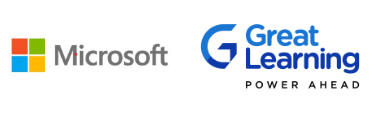
</center>

<center>
<h1><b>Classification tasks with Azure Open AI</b>
</center>

# Introduction

Welcome! In this MLS, we are going to look into the E-commerce aggregators business. Aggregator platforms face multiple challenges due to their unorganised nature. One such problem is the task of categorising products. Since the sellers on the platform aren't organised, they tend to mislabel some of their products. This leads to confusion in the customers leading to dissatisfaction and ultimately revenue loss. The management had tried to educate the sellers on labelling through hand-outs however, that hasn't been successfull. So they are looking to automate labeling using AI.

**Task 1: Auto-Labelling System**

Initially, our focus is on categories with the highest incidence of mislabeling. Currently, we are facing a 27% mislabeling in the system. One of the reasons this is happening is because there are a lot of common words between the skin care and hair care categories. Both of them have words like oil, powder, wash, etc. It is also confusing as sometimes products for body hair can be categorised as skin care and other times as hair care. Similarly, products for scalp can be basketed into skin care or hair care.Our job is to reduce this as much as possible.

1. Skin Care
2. Hair Care

**Task 2: Customer Intent Analysis**

Management also has received concerns about the usability of the website. They aim to enhance the user experience on our platform by gaining insights into the problems customers are facing. One good source of understanding where customers are having trouble is by looking at the concerns raised by customers with call support. Understanding customer intent in chat support messages will inform the management where improvements are needed in the platform's UI/UX, making navigation and usage more intuitive.

The data science team is entrusted with classifying customer intent into the relevant categories.

Due to resource constraints, we must utilize a small dataset for model training.


Let's start by setting up our code environment.

## Setup

## Installation

In [ ]:
!pip install openai==1.2.0 tiktoken datasets session-info --quiet

## Imports

In [ ]:
# Import all Python packages required to access the Azure Open AI API.
# Import additional packages required to access datasets and create examples.

import json
import random
import tiktoken
import session_info

import pandas as pd
import numpy as np

from openai import AzureOpenAI

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Authentication

In [ ]:
with open('config_v1_2.json', 'r') as az_creds:
    data = az_creds.read()

In [ ]:
creds = json.loads(data)

In [ ]:
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [ ]:
deployment_name = creds["CHATGPT_MODEL"]

## Utilities

While developing the solution, we need to be mindful of the costs it will incurr for the business. Even a good solution that comes at a high cost is not useful for the business. For LLMs, costs are associated with the number of tokens consumed. Let's create a function using tiktoken to understand the number of tokens we are using in each of out prompts. This information will be cruicial while deciding the final technique we are going to use to solve the problem.

In [ ]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

## Task 1: Auto-Label Classificaation

Let's have a look at the data and get a feel of it.

### Preparing Data

In [ ]:
data = pd.read_csv("auto-labelling.csv")

In [ ]:
data.head(10)

In [ ]:
data.Category.value_counts()

Note how the dataset is evenly balanced with equal number of reviews assembled for each of the category. This makes our life easy.

Since this is a classification exercise with a balanced dataset, we can use accuracy as our metric. We need to also be mindful of the tokens consumed for each prompt as this is going to be a perpetual task for the business as new products are added everyday.

#### Test and Train Split

Let us split the data into two segments - one segment that gives us a pool to draw few-shot examples from and another segment that gives us a pool of gold examples which will be used for testing.

In summary, we extract a dataset from a corpus by processing required fields. Each example should contain the text input and an annotated label. Once we create examples and gold examples from this dataset, this curated dataset is stored in a format appropriate for reuse (e.g., JSON).

To select gold examples for this session, we sample randomly from the test data using a `random_state=42`. This ensures that the examples from multiple runs of the sampling are the same (i.e., they are randomly selected but do not change between different runs of the notebook). Note that we are doing this only to keep execution times low for illustration. In practise, large number of gold examples facilitate robust estimates of model accuracy.

In [ ]:
examples_df, gold_examples_df = train_test_split(
    data, #<- the full dataset
    test_size=0.8, #<- 80% random sample selected for gold examples
    random_state=42, #<- ensures that the splits are the same for every session
    stratify=data['Category'] #<- ensures equal distribution of labels
)

In [ ]:
gold_examples = (
        gold_examples_df.to_json(orient='records')
)

In [ ]:
(examples_df.shape, gold_examples_df.shape)

In [ ]:
gold_examples_df.head(3)

With everything setup, let's start working on our prompts.

### Step 3: Derive Prompt

#### Create prompts

In [ ]:
user_message_template = """```{product_description}```"""

Let's create a zero-shot prompt for this scenario. We need to make sure that LLM outputs only the category label and not explanation. So, let's add explicit instructions for that.

**Prompt 1: Zero-shot**

In [ ]:
zero_shot_system_message = """
Classify the following product desciption presented in the input into one of the following categories.
Categories - ['Hair Care', 'Skin Care']
Product description will be delimited by triple backticks in the input.
Answer only 'Hair Care' or 'Skin Care'. Nothing Else. Do not explain your answer.
"""

In [ ]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

Let's check the number of tokens this prompt consumes.

In [ ]:
num_tokens_from_messages(zero_shot_prompt)

**Let's try our zero-shot prompt on a single example.**

In [ ]:
data.iloc[0,:]

In [ ]:
input_description = data.iloc[0,0]

user_input = [
    {
        'role':'user',
        'content': user_message_template.format(product_description = input_description)
    }
]

Let's also cap the max_token parameter to 4 so that the model doesn't output explanations. We are capping it at 4 instead of 2 because we want to leave a little lee-way for punctuation marks and sub-words token that the model might output in the middle of the text. It is better to use regex later than to prematurely over-constrain the LLM output.

In [ ]:
response = client.chat.completions.create(
    model=deployment_name,
    messages=zero_shot_prompt+user_input,
    temperature=0, # <- Note the low temperature
    max_tokens=4 # <- Note how we restrict the output to not more than 2 tokens
)
print(response.choices[0].message.content)

Great! That's a hit. Let's scale it. Let's create a generic evaluation function that can be used with all the prompting techniques that we are going to use.

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template,samples_to_output = 10):

    """
    Return the accuracy score for predictions on gold examples.
    For each example, we make a prediction using the prompt. Gold labels and
    model predictions are aggregated into lists and compared to compute the
    accuracy.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for product description
        samples_to_output (int): number of sample predictions and ground truths to print

    Output:
        accuracy (float): Accuracy computed by comparing model predictions
                                with ground truth
    """

    count =0
    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_input = example['Product Description']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(product_description=gold_input)
            }
        ]

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=prompt+user_input,
                temperature=0, # <- Note the low temperature
                max_tokens=4 # <- Note how we restrict the output to not more than 4 tokens
            )

            prediction = response.choices[0].message.content
            # print(prediction) #uncomment to see LLM response or to debug
            model_predictions.append(prediction.strip().lower()) # <- removes extraneous white space and lowercases output
            ground_truths.append(example['Category'].strip().lower())

            if count < samples_to_output:
              count += 1
              print("Product Description: \n", example['Product Description'],"\n")
              print("Original label: \n", example['Category'],"\n")
              print("Predicted label: \n", prediction)
              print("====================================================")

        except Exception as e:
            print(e)
            continue

        accuracy = accuracy_score(ground_truths, model_predictions)

    return accuracy

In [ ]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template)

Decent start. Now, let's check if few-shot can do a better job.

**Prompt 2: Few-shot**

For the few-shot prompt, there is no change in the system message compared with the zero-shot prompt. However, we augment this system message with few shot examples.  

In [ ]:
few_shot_system_message = """
Classify the following product desciption presented in the input into one of the following categories.
Categories - ['Hair Care', 'Skin Care']
Product description will be delimited by triple backticks in the input.
Answer only 'Hair Care' or 'Skin Care'. Do not explain your answer.
"""

To assemble few-shot examples, we will need to sample the required number of reviews from the training data. One approach would be to  first subset the different categories and then select samples from these subsets.

In [ ]:
hc_reviews = (examples_df.Category == 'Hair Care')
sc_reviews = (examples_df.Category == 'Skin Care')

In [ ]:
hc_examples = examples_df.loc[hc_reviews, :].sample(4)
sc_examples = examples_df.loc[sc_reviews, :].sample(4)

In [ ]:
hc_examples

To reiterate from our learnings from the week, merely selecting random samples from the category subsets is not enough because the examples included in a prompt are prone to a set of known biases. LLMs are known to respond with the most frequent label in the examples or the labels that were given at the end of the prompt.



To avoid these biases, it is important to have a balanced set of examples that are arranged in random order. Let us create a Python function that generates bias-free examples (our function implements the workflow presented below):

In [ ]:
def create_examples(dataset, n=4):

    """
    Return a JSON list of randomized examples of size 2n with two classes.
    Create subsets of each class, choose random samples from the subsets,
    merge and randomize the order of samples in the merged list.
    Each run of this function creates a different random sample of examples
    chosen from the training data.

    Args:
        dataset (DataFrame): A DataFrame with examples (text + label)
        n (int): number of examples of each class to be selected

    Output:
        randomized_examples (JSON): A JSON with examples in random order
    """

    hc_reviews = (examples_df.Category == 'Hair Care')
    sc_reviews = (examples_df.Category == 'Skin Care')

    cols_to_select = ["Product Description","Category"]
    hc_examples = examples_df.loc[hc_reviews, cols_to_select].sample(n)
    sc_examples = examples_df.loc[sc_reviews, cols_to_select].sample(n)

    examples = pd.concat([hc_examples,sc_examples])
    # sampling without replacement is equivalent to random shuffling
    randomized_examples = examples.sample(2*n, replace=False)

    return randomized_examples.to_json(orient='records')

In [ ]:
examples = create_examples(examples_df, 2)

In [ ]:
json.loads(examples)

Let's create a function to create few show prompt from our examples.

In [ ]:
def create_prompt(system_message, examples, user_message_template):

    """
    Return a prompt message in the format expected by the Open AI API.
    Loop through the examples and parse them as user message and assistant
    message.

    Args:
        system_message (str): system message with instructions for classification
        examples (str): JSON string with list of examples
        user_message_template (str): string with a placeholder for description

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]

    for example in json.loads(examples):
        example_description = example['Product Description']
        example_category = example['Category']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    product_description=example_description
                )
            }
        )

        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_category}"}
        )

    return few_shot_prompt

In [ ]:
few_shot_prompt = create_prompt(
    few_shot_system_message,
    examples,
    user_message_template
)

In [ ]:
few_shot_prompt

The few-shot prompt is definetely heavier than the zero-shot prompt. Let's check how much more resource intensive few-shot is.

In [ ]:
num_tokens_from_messages(few_shot_prompt)

That is 3x more token usage than zero-shot. Unless it gives significatnly better results, zero-shot will be the preferred one.

In [ ]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

Let's take the final call after running through all prompting techniques and after running the evaluation across multiple samples.

**Prompt 3: Chain-of-Thought**

For the CoT prompt, we add detailed step-by-step instructions to the few shot system message instructing the model to carefully ponder before assigning the label. Apart from this addition, there are no further changes from the few-shot prompt.

In [ ]:
cot_system_message = """
Given the following product description, follow these steps to determine the appropriate product label category:

1. Read the product description carefully, looking for key words and phrases that indicate the product's purpose and usage.

2. Consider if the description mentions any particular keywords relating to a category.

3. If the description contains keywords related to multiple categories, determine which category is most strongly emphasized or which usage is primary.

4. If the description does not contain any clear keywords related to the given categories, consider the overall context and purpose of the product to make an educated guess about the most appropriate category.

5. Output the determined category label ( 'Hair Care', or 'Skin Care') and nothing else. Do not explain your output.
"""

In [ ]:
cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

In [ ]:
cot_few_shot_prompt

Note that the examples remain the same while the system message changes.

In [ ]:
num_tokens_from_messages(cot_few_shot_prompt)

We can see that token consumption per example is highest in cot_fewshot followed by fewshot and the least by zero-shot. As the business has to process a lot of products, we need to make sure the token consumption is low as openAI charges the business per token basis. Even small improvements in the token consumption while keeping the accuracies can have a huge impact.

Let's check the cot-fewshot prompt and see if it's worth the token it is consuming.

In [ ]:
evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

We have done evaluations of all three pormpting techniques. Now, let's sample different examples for the few-shot and CoT-few-shot prompts and evaluate them across multiple samples.

In [ ]:
num_eval_runs = 5

In [ ]:
few_shot_performance, cot_few_shot_performance = [], []

In [ ]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(examples_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)
    cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)
    cot_few_shot_accuracy = evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_accuracy)
    cot_few_shot_performance.append(cot_few_shot_accuracy)

In [ ]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

In [ ]:
np.array(cot_few_shot_performance).mean(), np.array(cot_few_shot_performance).std()

Both of them are consistent across iterations.

All of them beat the existing mis-labeling rate. We can see that both zero-shot and few-shot have out performed cot-fewshot. It is imperative for us to use zero-shot over few-shot as the accuracy scores are similar but zero-shot consumes 3X lesser tokens and hence becomes the obvious choice.

## Task 2: Intent Detection

Let's proceed to the second task, which involves determining customer intent from support queries. We have received a raw dataset of these queries and are required to conduct a preliminary analysis. Our goal is to identify various categories of inquiries and determine the most frequent ones. Based on this analysis, management will establish a labeling team to manually classify the queries into the top three categories, with a fourth category, 'Others,' for queries that do not fit into the top three.

Following this step, we will undertake a classification task using OpenAI's tools. If the results are satisfactory (i.e., accuracy greater than 85%), we will apply the model to the entire dataset to determine the actual frequency of each category. The category with the highest occurrence will be prioritized for action.

During this session, our focus will be on the initial exploration, construction, and evaluation of the classification task using a large language model (LLM).

### Step 2: Assemble and Explore Data

In [ ]:
dataset = pd.read_csv("customer_intent_raw.csv")

In [ ]:
dataset.head()

In [ ]:
dataset.shape

We are given an unlabeled dataset. First, let's try to understand what sort of problems are present in the data and which of them are most frequent using an LLM.

Let's concatenate all the responses into one string and then pass it to the LLM and ask it to provide us this preliminary analysis.

In [ ]:
raw_intent = dataset['description'].str.cat(sep=' || ')

In [ ]:
raw_intent

Let us now craft a prompt.

In [ ]:
prompt = f"""Extract the list of problems faced by the user from the following customer queries, separated by " || ". A problem category should be a two word label. List out 10 unique problems
Then, identify the top 5 most frequent problem encountered by the user.

Customer queries:
{raw_intent}"""

In [ ]:
messages = [{'role':'user','content':prompt}]

In [ ]:
response = client.chat.completions.create(
    model=deployment_name,
    messages=messages,
    temperature = 0,
    seed = 49
)

print(response.choices[0].message.content)

The response from the LLM will vary every time we re-generate it. Since we are doing an unsupervised task and since the LLM has no concrete idea about the problem beforehand, it is expected that there will be some variance. We can iterate over this multiple times and check the outputs each times to figure out the most consistent responses. By doing that, we have a higher chance of actually finding out which of the labels is most frequent. Ideally this should be done on the whole data corpus. Each time sampling a different subset (so that we can fit the context length of the LLM). But in this case-study, we do not have the whole datset (thousands of customer queries). Hence, we don't need to sample the dataset. Instead, we can run the LLM through the data multiple times and find out the most frequent query category (most probably).

You are encouraged to re-run the above cell multiple times (4-5) to check which are the most consistent labels. Find 2-3 labels that are most consistent in those runs. From our runs, we found the following labels consistent - Modifying order(change order), track order, payment issues, account related issues. Of these three labels, modifying orders, payment issues and lastly track order are the most important ones to fix as they are directly related to revenue. Account related issues is a second priority. Let's look at change order, track oder and payment issues can be further investigated at large scale to understand which of these three is most problematic.

The whole classification task would have been a bigger project than actually correcting the three issues if it weren't for LLMs. The NLP classification itself would have taken multiple weeks. However, with LLMs, the whole task can be done within a week.

Using this preliminary exploration, a labeling team has been setup to categorize a sample of the data into the following categories - 'track order', 'change order', 'payment issues', and 'others'.

Note: We recommend you use the labeled data provided even if your analysis has resulted in a different set of frequent categories (it is a rare chance). Since we have a synthetic data on our hands currently, and since the dataset is rather small, we have to make such choices.

Let's import the labeled data.

In [ ]:
dataset_df = pd.read_csv("customer_intent_labeled.csv")

In [ ]:
dataset_df.task.unique()

Let's check the different categories of customer inquiries.

In [ ]:
examples_df, gold_examples_df = train_test_split(
    dataset_df, #<- the full dataset
    test_size=0.6, #<- 60% random sample selected for gold examples as we will only need few examples for few-shot
    random_state=42 #<- ensures that the splits are the same for every session
)

Let's have a feel of the data before we move forward.

In [ ]:
examples_df.sample(10)

In [ ]:
gold_examples = json.loads((gold_examples_df.sample(100, random_state=42).to_json(orient='records')
))

Let's derive prompts for this scenario.

### Step 3: Derive Prompt

#### Create prompts

In [ ]:
user_message_template = """```{description}```"""

**Zero-shot prompt**

Let's craft our zero-shot such that the model doesn't respond with an explanation or output a new label that's not one of our pre-determined labels.

In [ ]:
zero_shot_system_message = """Classify the following product desciption presented in the input into one of the following categories.
Categories - ['change order', 'track order', 'payment issue', 'others']
Product description will be delimited by triple backticks in the input.
Answer only 'change order',
 or 'track order', or 'payment issue',or 'others'. Nothing Else. Do not explain your answer.
"""

In [ ]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

In [ ]:
num_tokens_from_messages(zero_shot_prompt)

**Few-shot prompt**

Let's also create a few-shot prompt. We can evaluate both zero-shot and few-shot at the same time later.

In [ ]:
few_shot_system_message = """Classify the following product desciption presented in the input into one of the following categories.
Categories - ['change order', 'track order', 'payment issue']
Product description will be delimited by triple backticks in the input.
Answer only 'change order', or 'track order', or 'payment issue'. Nothing Else. Do not explain your answer.
"""

In [ ]:
def create_examples(dataset, n=4):

    """
    Return a JSON list of randomized examples of size 2n with two classes.
    Create subsets of each class, choose random samples from the subsets,
    merge and randomize the order of samples in the merged list.
    Each run of this function creates a different random sample of examples
    chosen from the training data.

    Args:
        dataset (DataFrame): A DataFrame with examples (text + label)
        n (int): number of examples of each class to be selected

    Output:
        randomized_examples (JSON): A JSON with examples in random order
    """

    task1 = (examples_df.task == 'change order')
    task2 = (examples_df.task == 'track order')
    task3 = (examples_df.task == 'payment issue')
    task4 = (examples_df.task == 'others')

    t1_examples = examples_df.loc[task1, :].sample(n)
    t2_examples = examples_df.loc[task2, :].sample(n)
    t3_examples = examples_df.loc[task3, :].sample(n)
    t4_examples = examples_df.loc[task4, :].sample(n)
    examples = pd.concat([t1_examples,t2_examples,t3_examples,t4_examples])
    # sampling without replacement is equivalent to random shuffling
    randomized_examples = examples.sample(4*n, replace=False)

    return randomized_examples.to_json(orient='records')

In [ ]:
def create_prompt(system_message, examples, user_message_template):

    """
    Return a prompt message in the format expected by the Open AI API.
    Loop through the examples and parse them as user message and assistant
    message.

    Args:
        system_message (str): Instructions for the model for classfication
        examples (JSON): JSON list of examples representative of each category
        user_message_template (str): string with a placeholder for query

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]

    for example in json.loads(examples):

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    description=example['description']
                )
            }
        )

        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example['task']}"}
        )

    return few_shot_prompt

In [ ]:
examples = create_examples(examples_df,2)
gold_examples = create_examples(gold_examples_df,10)
few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

In [ ]:
json.loads(gold_examples)[0]

Let's check the few shot prompt.

In [ ]:
few_shot_prompt

#### Evaluate prompts

Let's evaluate our zero-shot and few-shot prompts.

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template, samples_to_output = 10):

    """
    Return the accuracy for predictions on gold examples.
    For each example, we make a prediction using the prompt. Gold labels and
    model predictions are aggregated into lists and compared to compute the
    accuracy.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for description
        samples_to_output (int): number of sample predictions and ground truths to print

    Output:
        accuracy (float): accuracy score computed by comparing model predictions
                                with ground truth
    """
    count = 0
    model_predictions, ground_truths = [], []

    # Iterating through all the gold examples and constructing the messages dictionary using the text from example

    for example in json.loads(gold_examples):
        gold_input = example['description']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(description=gold_input)
            }
        ]

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=prompt+user_input,
                temperature=0, # <- Note the low temperature
                max_tokens=4 # <- Note how we restrict the output to not more than 2 tokens
            )

            prediction = response.choices[0].message.content
            model_predictions.append(prediction.strip().lower()) # <- removes extraneous white space and lowercases output
            ground_truths.append(example['task'].strip().lower())

            if count < samples_to_output:
              count += 1
              print("Original label: \n", example['task'],"\n")
              print("Predicted label: \n", prediction)
              print("================================")

        except Exception as e:
            print(e)
            continue


    accuracy = accuracy_score(ground_truths, model_predictions)

    return accuracy

In [ ]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template)

In [ ]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

That is a good result! Let's see if it is consistent across multiple samples.

In [ ]:
num_eval_runs = 5

In [ ]:
few_shot_performance = []

Let's modify the original evaluate function in such a way that it prints the accuracy for every ground truth label and the overall accuracy for every round of evaluation.

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template,samples_to_output = 10):

    """
    Return the accuracy score for predictions on gold examples.
    For each example, we make a prediction using the prompt. Gold labels and
    model predictions are aggregated into lists and compared to compute the
    accuracy.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for description.
        samples_to_output (int): number of sample predictions and ground truths to print

    Output:
        accuracy (float): accuracy score computed by comparing model predictions
                                with ground truth
    """
    count = 0
    model_predictions, ground_truths = [], []

    # Iterating through all the gold examples and constructing the messages dictionary using the text from example

    for example in json.loads(gold_examples):
        gold_input = example['description']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(description=gold_input)
            }
        ]

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=prompt+user_input,
                temperature=0, # <- Note the low temperature
                max_tokens=4 # <- Note how we restrict the output to not more than 2 tokens
            )

            prediction = response.choices[0].message.content
            while count < samples_to_output:
              count += 1
              print("Original label: \n", example['task'],"\n")
              print("Predicted label: \n", prediction)


            model_predictions.append(prediction.strip().lower()) # <- removes extraneous white space and lowercases output
            ground_truths.append(example['task'].strip().lower())

        except Exception as e:
            print(e)
            continue


    # Find the accuracy of each category.

    df = pd.DataFrame({
    'Predictions': model_predictions,
    'Ground Truth': ground_truths
    })
    labels = df['Ground Truth'].unique()

    # Create a new DataFrame for the accuracies
    accuracy_df = pd.DataFrame(columns=labels)

    for label in labels:
        # Filter rows where Ground Truth is the current label
        subset = df[df['Ground Truth'] == label]

        # Calculate accuracy for the current label
        accuracy = accuracy_score(subset['Ground Truth'], subset['Predictions'])

        # Add accuracy to the DataFrame
        accuracy_df.loc[0, label] = accuracy

    print("\n\n", accuracy_df)
    print("====================================================")

    accuracy = accuracy_score(ground_truths, model_predictions)

    return accuracy

In [ ]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(dataset_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_accuracy)


Let's check the average accuracy across runs

In [ ]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

We got a good result with few-shot technique across multiple samples.

We can observe that most of the mislabeling is happening the specific case where the original label was others and then the LLM instead of placing it in others is misclassifying it into the other categories. Majority of the inaccuracy is thus from this case. This particular case is not that troubling for the business. The opposite of this, which is classifying a label that is not labelled as others into others will mean that an important issue has been mislabeled into a non-major label.

We can also manually check these missed cases to analyze this further.

Let's modify the evaluate prompt so that it prints the query along with the ground truth label and prediction. This will help us see where the LLM is getting it wrong.

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template,samples_to_output = 10):

    """
    Return the accuracy score for predictions on gold examples.
    For each example, we make a prediction using the prompt. Gold labels and
    model predictions are aggregated into lists and compared to compute the
    accuracy.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for description
        samples_to_output (int): number of sample predictions and ground truths to print

    Output:
        accuracy (float): accuracy score computed by comparing model predictions
                                with ground truth
    """
    count = 0
    model_predictions, ground_truths = [], []

    # Iterating through all the gold examples and constructing the messages dictionary using the text from example

    for example in json.loads(gold_examples):
        gold_input = example['description']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(description=gold_input)
            }
        ]

        try:
            response = client.chat.completions.create(
                model=deployment_name,
                messages=prompt+user_input,
                temperature=0, # <- Note the low temperature
                max_tokens=4 # <- Note how we restrict the output to not more than 2 tokens
            )

            prediction = response.choices[0].message.content
            while count < samples_to_output:
              count += 1
              print("Description: \n", example['description'],"\n")
              print("Original label: \n", example['task'],"\n")
              print("Predicted label: \n", prediction)
              print("====================================================")
            model_predictions.append(prediction.strip().lower()) # <- removes extraneous white space and lowercases output
            ground_truths.append(example['task'].strip().lower())

        except Exception as e:
            print(e)
            continue


    # Find the accuracy of each category.

    df = pd.DataFrame({
    'Predictions': model_predictions,
    'Ground Truth': ground_truths
    })
    labels = df['Ground Truth'].unique()

    # Create a new DataFrame for the accuracies
    accuracy_df = pd.DataFrame(columns=labels)

    for label in labels:
        # Filter rows where Ground Truth is the current label
        subset = df[df['Ground Truth'] == label]

        # Calculate accuracy for the current label
        accuracy = accuracy_score(subset['Ground Truth'], subset['Predictions'])

        # Add accuracy to the DataFrame
        accuracy_df.loc[0, label] = accuracy

    print("\n\n", accuracy_df,"\n\n")

    accuracy = accuracy_score(ground_truths, model_predictions)

    return accuracy

In [ ]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

If you run this with multiple samples, you see that the mislabelling is sometimes due to mislabelling during the manual labeling process and the LLM is actually getting it right and the problem is with the manual labeling itself. In cases where it's not due to manual mislabeling, it is an edge case where the label could have gone either way. Overall our analysis shows that the LLM model is a good proxy and can be used to find the most troubling UX experience.

We can go ahead and use the model to segregate user queries. Post this step, a dashboard can be prepared to show the most frequent labels we have found. This will reveal the most frequent problem encountered by the users.

**Power Ahead!**